17:31:33: Image capture for http://192.168.1.102 


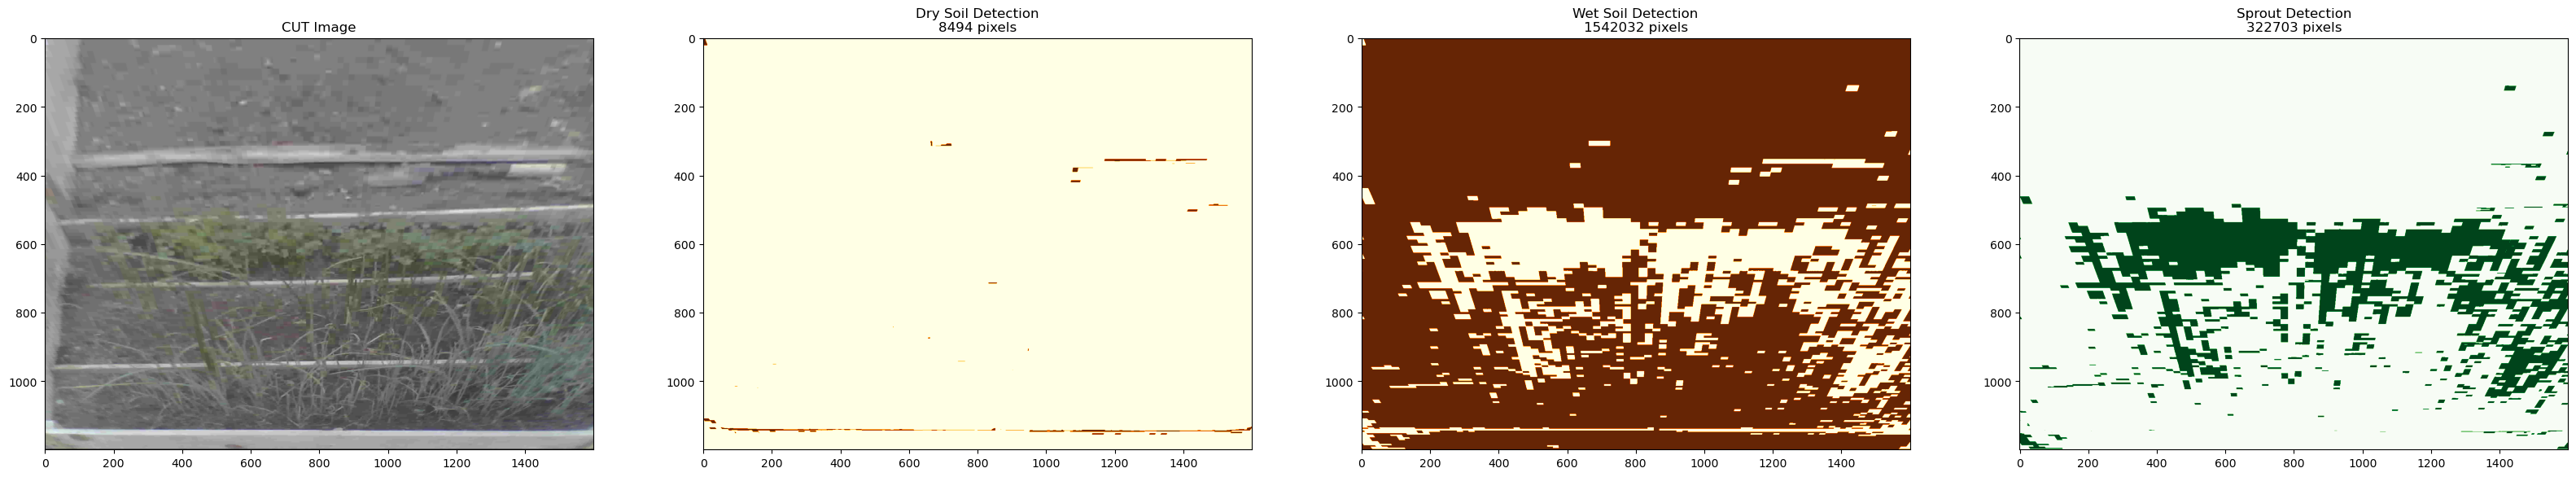

17:32:03: Image capture for http://192.168.1.167 


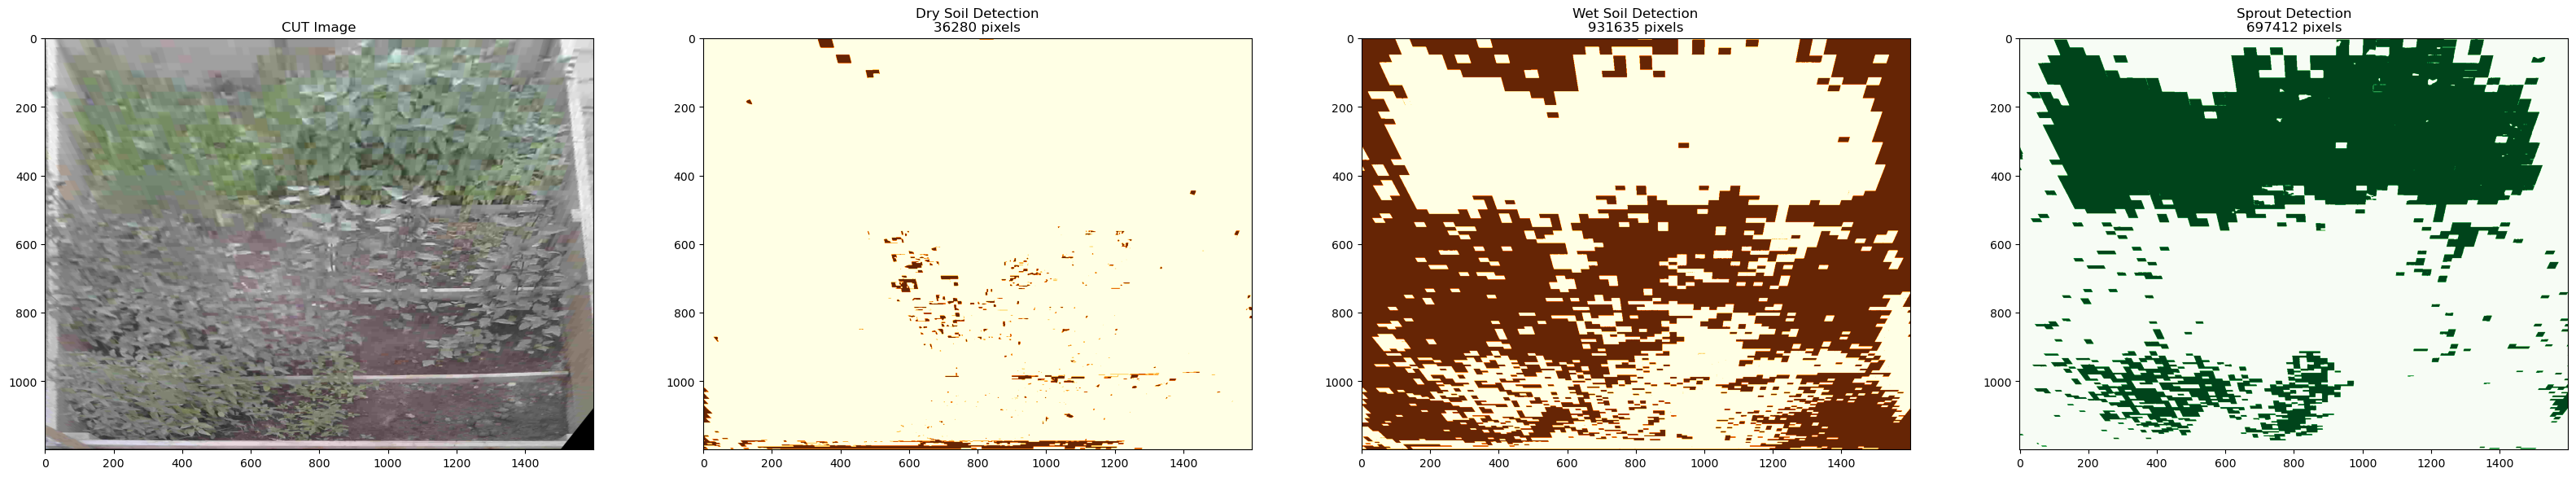

17:32:33: Image capture for http://192.168.1.184 


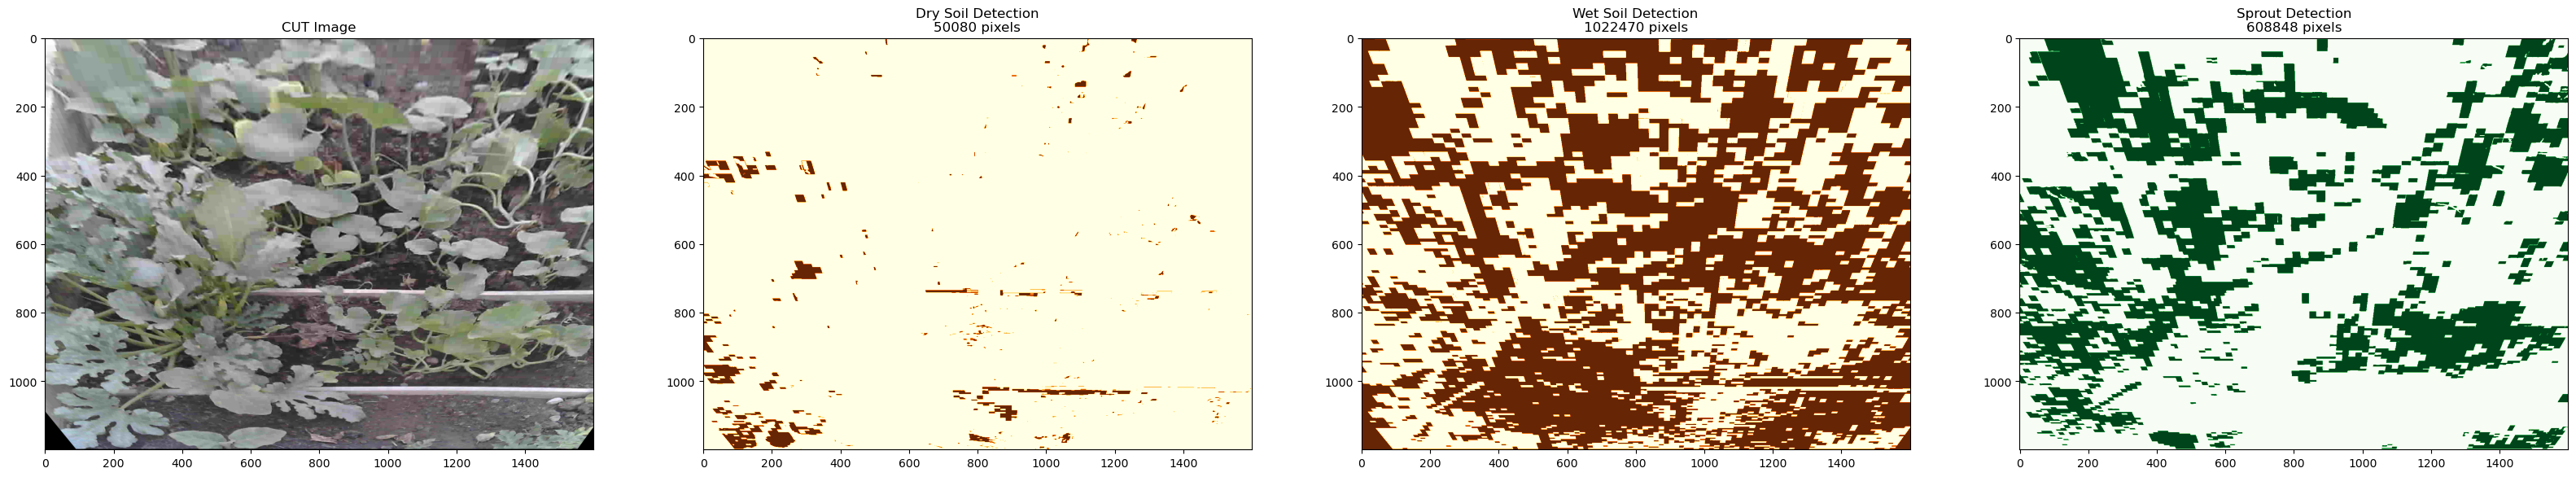

17:33:03: Image capture for http://192.168.1.131 


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from datetime import datetime
import requests
from requests.exceptions import ConnectionError
import time
import csv
import logging

# Set up logging
logging.basicConfig(filename='monitoring.log', level=logging.INFO, format='%(asctime)s %(message)s')


################################################################
# Set the IP address and port of the ESP32 server
ESP_IP = "192.168.1.200"                                                    # <<<<<<<<<<<<<<<<<<<===========
ESP_PORT = 80
################################################################
MIN_LIGHT = 40
SUNNY = 400 #lumen
MIN_DRY = 10000 # pixels
WETDRY = 50 # %
################################################################
watering_cycle = 4 # min
long_sleep = 30 # min
short_sleep = 10 # min
################################################################
# Define color range for dry soil, wet soil, and sprouts (green)            # <<<<<<<<<<<<<<<<<<<===========
# These values are in HSV color space
dry_soil_color_range = [(101 , 0, 143), (179 , 255, 225)]  #  (0 , 0, 111), (5 , 255, 121)
wet_soil_color_range = [(0 , 0, 0), (0 , 255, 255)]  #  (0 , 0, 111), (5 , 255, 121)
sprout_color_range = [(31 , 22, 20), (96 , 255, 255)]  # TODO: Adjust based on your actual sprout color
#################################################################
# Define the corners of each garden in the image
# This is a list of four points in (x, y) format
garden_corners = {                                                          # <<<<<<<<<<<<<<<<<<<===========
    "192.168.1.102": [(430, 30), (1150, 30), (1600, 1200), (0,1200)],       # <<<<<<<<<<<<<<<<<<<===========
    "192.168.1.167": [(600, 150), (1250, 150), (1700, 1200), (0,1200)],     # TODO: Replace these values with your actual corners
    "192.168.1.184": [(430, 30), (1200, 30), (1650, 1200), (-100,1200)],
    "192.168.1.131": [(300, 0), (1100, 0), (1600, 1200), (0,1200)],
    
}
# Assign pump number to each IP
pump_numbers = {
    "192.168.1.102": 0,                                                     # <<<<<<<<<<<<<<<<<<<===========
    "192.168.1.167": 1,                                                     # <<<<<<<<<<<<<<<<<<<===========
    "192.168.1.184": 2,
    "192.168.1.131": 3,
}

#################################################################

def capture_image(url, save_path):
    # Capture image from the ESP32-CAM
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raises stored HTTPError, if one occurred.
        img = Image.open(BytesIO(response.content))
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        img.save(os.path.join(save_path, f'{timestamp}.jpg'))
        return img
    except requests.HTTPError as http_err:
        logging.info(f'HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        logging.info(f'Error occurred: {err}')
        return None

def detect_soil_color(img, color_range):
    img_opencv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2HSV)
    lower_color = np.array(color_range[0])
    upper_color = np.array(color_range[1])
    mask = cv2.inRange(img_opencv, lower_color, upper_color)
    res = cv2.bitwise_and(img_opencv, img_opencv, mask=mask)
    num_pixels = cv2.countNonZero(mask)
    return mask, res, num_pixels

def save_detection_to_csv(timestamp, num_dry_pixels, num_wet_pixels, num_sprout_pixels, csv_path):
    data = {
        'timestamp': timestamp,
        'num_dry_pixels': num_dry_pixels,
        'num_wet_pixels': num_wet_pixels,
        'num_sprout_pixels': num_sprout_pixels
    }
    df = pd.DataFrame([data])
    df.to_csv(csv_path, mode='a', header=not os.path.exists(csv_path), index=False)

def transform_perspective(img, corners, output_size=(1600, 1200)):
    # Convert the corners to a numpy array
    corners = np.float32(corners)
    
    # Define the output corners
    output_corners = np.float32([[0, 0], [output_size[0] - 1, 0], [output_size[0] - 1, output_size[1] - 1], [0, output_size[1] - 1]])

    # Get the perspective transformation matrix
    M = cv2.getPerspectiveTransform(corners, output_corners)

    # Warp the image perspective
    img_warped = cv2.warpPerspective(np.array(img), M, output_size)

    return img_warped

# Define a function to get the sensor data from the ESP32
def get_sensor_data():
    try:
        response = requests.get(f"http://{ESP_IP}:{ESP_PORT}/sensor_data")
        logging.info(f"Initializing...")
        logging.info(f"Connecting to ESP32 @ http://{ESP_IP}:{ESP_PORT} ")
        response.raise_for_status()
        
        return response.json()
    
        if response.status_code == 200:
            data = response.json()
            logging.info(f"Sensor data: {data}")
            return data
        
    except requests.exceptions.HTTPError as err:
        logging.error(f"HTTP error occurred: {err}")
        
    except Exception as err:
        logging.error(f"Other error occurred: {err}")
        
    except ConnectionError:
        logging.error(f"Failed to connect to {ip_address}. Please check the connection.")
        
        return None

# Define a function to update the data on the ESP32
def update_data(dry_count, moist_count, germination_count, wet_soil_ratio, germination_avg):
    data = {
        'dry_count': dry_count,
        'moist_count': moist_count,
        'germination_count': germination_count,
        'wet_soil_ratio': wet_soil_ratio,
        'germination_avg': germination_avg
    }
    response = requests.post(f"http://{ESP_IP}:{ESP_PORT}/update_data", json=data)
    if response.status_code == 200:
        logging.info(f"Update successful, response: {response.json()}")
    else:
        logging.info(f"Update failed, response code: {response.status_code}")
    
# Define a function to control the pump
def control_pump(state, pump_number):
    response = requests.get(f"http://{ESP_IP}:{ESP_PORT}/control_pump?state={state}&pump={pump_number}")
    if response.status_code == 200:
        watering_time = datetime.now() # Capture the time the pump was activated
        watering_time = datetime.now().strftime("%H:%M:%S")
        logging.info(f"Pump {pump_number} control successful, response: {response.text}")
    else:
        logging.info(f"Pump control {pump_number} failed, response code: {response.status_code}")
    return watering_time

def save_data_to_csv(data, csv_path):
    # Check if file doesn't exist and write headers
    if not os.path.isfile(csv_path):
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["timestamp", "num_dry_pixels", "num_wet_pixels", "num_sprout_pixels", "temperature", "humidity", "pressure", "light_level", "start_watering_time", "stop_watering_time"])

    # Always append the data
    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([data["timestamp"], data["num_dry_pixels"], data["num_wet_pixels"], data["num_sprout_pixels"], data["temperature"], data["humidity"], data["pressure"], data["light_level"], data["start_watering_time"], data["stop_watering_time"]])

def predict_disease(image_path):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((180, 180))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Return the predicted class
    return predicted_class
        
#############################################################################################        
def main():
#############################################################################################     
    
     
    for ip_address, corners in garden_corners.items():
        url = f"http://{ip_address}/capture"
        image_save_path = os.path.join(os.getcwd(), 'images', ip_address.replace('.', '_'))
        detection_save_path = os.path.join(os.getcwd(), 'detections', ip_address.replace('.', '_'))
        csv_path = os.path.join(os.getcwd(), 'data', f'{ip_address.replace(".", "_")}_soil_data.csv')

        if not os.path.exists(image_save_path):
            os.makedirs(image_save_path)
        if not os.path.exists(detection_save_path):
            os.makedirs(detection_save_path)
        if not os.path.exists(os.path.dirname(csv_path)):
            os.makedirs(os.path.dirname(csv_path))
        
        logging.info(f"Ready to capture image!")
        
        logging.info(f"Image capture for http://{ip_address} ")
        
        now = datetime.now().strftime("%H:%M:%S")
        
        print(f"{now}: Image capture for http://{ip_address} ")
    
        img = capture_image(url, image_save_path)
        if img is None:
            logging.info(f"Image capture failed for IP {ip_address}.")
            continue

        # Transform the image perspective to focus on the garden
        raw_img = img
        
        # Show the original image, dry soil mask, wet soil mask, and sprout mask
        #plt.figure(figsize=(40, 10))
        #plt.subplot(141)
        #plt.imshow(raw_img)
        #plt.title('Original Image')
        #plt.show()
        
        logging.info(f"")
        logging.info(f"Cropping the image to ROI")
        img = Image.fromarray(transform_perspective(np.array(img), corners))
        

        # Detect dry and wet soil, and sprouts
        logging.info(f"Detecting dry and wet soil, and sprouts...")
        mask_dry, _, num_dry_pixels = detect_soil_color(img, dry_soil_color_range)
        mask_wet, _, num_wet_pixels = detect_soil_color(img, wet_soil_color_range)
        mask_sprouts, _, num_sprout_pixels = detect_soil_color(img, sprout_color_range)

        # Save detection result to csv
        timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        #save_detection_to_csv(timestamp, num_dry_pixels, num_wet_pixels, num_sprout_pixels, csv_path)
        
        
        # Show the original image, dry soil mask, wet soil mask, and sprout mask
        plt.figure(figsize=(40, 10))

        plt.subplot(141)
        plt.imshow(img)
        plt.title('CUT Image')

        plt.subplot(142)
        plt.imshow(mask_dry, cmap='YlOrBr')
        plt.title(f'Dry Soil Detection\n{num_dry_pixels} pixels')

        plt.subplot(143)
        plt.imshow(mask_wet, cmap='YlOrBr')
        plt.title(f'Wet Soil Detection\n{num_wet_pixels} pixels')

        plt.subplot(144)
        plt.imshow(mask_sprouts, cmap='Greens')
        plt.title(f'Sprout Detection\n{num_sprout_pixels} pixels')

        plt.show()
        
        #######################################################################
        logging.info(f"")
        logging.info(f"..............................")
        logging.info(f"")
        
        total_pixels = num_dry_pixels + num_wet_pixels + num_sprout_pixels
        logging.info(f"num_dry_pixels:    {num_dry_pixels}")
        logging.info(f"num_wet_pixels:    {num_wet_pixels}")
        logging.info(f"num_sprout_pixels: {num_sprout_pixels}")
        logging.info(f"total_pixels:      {total_pixels}")
        soil_pixels = num_dry_pixels + num_wet_pixels
        logging.info(f"soil_pixels:       {soil_pixels}")

        wet_soil_ratio = num_wet_pixels / soil_pixels if soil_pixels != 0 else 0
        wet_soil_ratio *= 100
        logging.info(f"wet_soil_ratio:    {int(wet_soil_ratio)} %")
        germination_ratio = num_sprout_pixels / total_pixels if total_pixels != 0 else 0
        germination_ratio *= 100
        logging.info(f"germination_ratio: {int(germination_ratio)} %")
        
        logging.info(f"")
        logging.info(f"..............................")
        logging.info(f"")
        
        logging.info(f"Sending pixel data to ESP32...")
        update_data(num_dry_pixels, num_wet_pixels, num_sprout_pixels, wet_soil_ratio, germination_ratio)
        logging.info(f"Pixel info sent to ESP32")


        # Save the dry and wet soil detection images and sprout detection
        logging.info(f"Saving the detection images...")
        Image.fromarray(mask_dry).save(os.path.join(detection_save_path, f'{timestamp}_dry.jpg'))
        Image.fromarray(mask_wet).save(os.path.join(detection_save_path, f'{timestamp}_wet.jpg'))
        Image.fromarray(mask_sprouts).save(os.path.join(detection_save_path, f'{timestamp}_sprouts.jpg'))
        
        
        
        # Use sensor data to decide if the garden needs watering
        start_watering_time = 0
        stop_watering_time = 0
        # These thresholds are placeholders, please replace with actual values
        logging.info(f"Checking Light level and Dry pixels and Wet/Dry Ratio...")
        logging.info(f"Light set at:      {SUNNY}") 
        logging.info(f"Dry Pixels set at: {MIN_DRY}") 
        logging.info(f"Wet/Dry Ratio at:  {WETDRY} %")
        logging.info(f"..............................")
                                                                                        # <<<<<<<<<<<<<<<<<<<===========
        
        pump_number = pump_numbers[ip_address]
        # If it's not too sunny and dry, water the garden
        if sensor_data['light_level'] < SUNNY and num_dry_pixels > MIN_DRY: #and wet_soil_ratio < WETDRY :      
            start_watering_time = control_pump('on', pump_number)
            logging.info(f"Start watering_time {start_watering_time}  <===============")
            print(f"Start watering_time {start_watering_time} <===============")
            logging.info(f"Turning on the pump {pump_number}...")
            
            time.sleep(watering_cycle * 60)  # Keep the pump on for XX seconds          # <<<<<<<<<<<<<<<<<<<===========
            stop_watering_time = control_pump('off', pump_number)
            logging.info(f"STOP watering_time  {stop_watering_time}  <===============")
            print(f"STOP watering_time  {stop_watering_time}  <===============")
            logging.info(f"Turning off the pump...")
            print(f"Turning off the pump {pump_number}...")
        else:
            logging.info(f"Skip watering because either too sunny or too wet... ")
            
         # Create a dictionary with the data we want to save
        data = {
            "timestamp": datetime.now(),
            "num_dry_pixels": num_dry_pixels,
            "num_wet_pixels": num_wet_pixels,
            "num_sprout_pixels": num_sprout_pixels,
            "temperature": sensor_data['temperature'],
            "humidity": sensor_data['humidity'],
            "pressure": sensor_data['pressure'],
            "light_level": sensor_data['light_level'],
            "start_watering_time": start_watering_time,
            "stop_watering_time": stop_watering_time
        }

        # Save the data to the CSV file
        logging.info(f"Saving the data to the CSV file...")
        save_data_to_csv(data, csv_path)
        logging.info(f"")
        
#############################################################################################       
# Run the main function every XX minutes
while True:
    
    # Get the sensor data
    sensor_data = get_sensor_data()
    if sensor_data is None:
        logging.info(f"ERORR: sensor data is EMPTY!")
        logging.error(f"Failed to get sensor data. Skipping this iteration.")
        continue
        
    else:
        # If there's enough sunlight, run the main function
        logging.info(f"Min. Light set at:  {MIN_LIGHT}")
        if sensor_data['light_level'] > MIN_LIGHT :  #                       # <<<<<<<<<<<<<<<<<<<===========
            logging.info(f"Enough Light to Take images...")
            logging.info(f"Current level:      {sensor_data['light_level']}")
                  
            main()
                  
        else:
            logging.info(f"Due to lack of light, system is waiting...")
            # Sleep for XX sec                                               # <<<<<<<<<<<<<<<<<<<===========
            rest = (long_sleep * 60)
            now = datetime.now().strftime("%H:%M:%S")
            logging.info(f"Now system is resting for {rest/60} min. It's {now}")
            time.sleep(rest)

        # Waiting LOOP for XX sec                                             # <<<<<<<<<<<<<<<<<<<===========
        rest = (short_sleep * 60)
        now = datetime.now().strftime("%H:%M:%S")
        logging.info(f"Now system is sleeping for {rest/60} min. It's {now}")
        time.sleep(rest)
    